In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from collections import namedtuple

from script import get_rank

plt.style.use("seaborn")


In [2]:
# DATA LOADING

country_csv = "./data/EdStatsCountry.csv"
ed_stats_csv = "./data/EdStatsData.csv"

df_country = pd.read_csv(country_csv)
df_stats = pd.read_csv(ed_stats_csv)



<h3><u>Indicators selection :</u></h3>

<u>General :</u>

- SP.POP.1524.TO.UN => Population aged 15 to 24 => Target demography <br>
- IT.NET.USER.P2 => Internet access per 100 ppl <br>
- NY.GDP.PCAP.PP.KD => purchasing power parity - GDP per capita, PPP (constant 2011 international $)

<hr>

<u>Secondary :</u>
- UIS.NERT.2 => Total net enrolment rate, lower secondary, both sexes (%)
- BAR.SEC.CMPT.1519.ZS, Percentage of population age 15-19 with secondary schooling. Completed Secondary<br>
- BAR.SEC.ICMP.1519.ZS, Percentage of population age 15-19 with secondary schooling. Total (Incomplete and Completed Secondary)<br>
- Incomplete secondary_1519 = BAR.SEC.ICMP.1519.ZS - BAR.SEC.CMPT.1519.ZS <br>

<i>Note : the Baro Lee indicators will only be used to calculate the incompletion rate of 2000, 2005 & 2010, data missing for other years.</i>

<hr>

<u>Tertiary :</u>

- BAR.TER.CMPT.2024.ZS, Percentage of population age 20-24 with tertiary schooling. Completed Tertiary <br>
- BAR.TER.ICMP.2024.ZS, Percentage of population age 20-24 with tertiary schooling. Total (Incomplete and Completed Tertiary)<br>
- Incomplete tertiary_2024 = BAR.TER.ICMP.2024.ZS - BAR.TER.CMPT.2024.ZS<br>

<i>Note : the Baro Lee indicators will only be used to calculate the incompletion rate of 2000, 2005 & 2010, data missing for other years.</i>

<hr>

- Relevant Years : 2000 - 2020


c.f. data_validation.ipynb

In [3]:
# Filters Setup

past = np.arange(1969, 2000, 1)
future = np.arange(2020, 2101, 1)

indicators_list = [
    "UIS.NERT.2",
    "SP.POP.1524.TO.UN",
    "BAR.SEC.CMPT.1519.ZS",
    "BAR.SEC.ICMP.1519.ZS",
    "BAR.TER.CMPT.2024.ZS",
    "BAR.TER.ICMP.2024.ZS",
    "NY.GDP.PCAP.PP.KD",
    "IT.NET.USER.P2"
    ]


In [4]:
# Filters Application

for year in past:
    try:
        del df_stats[str(year)]
    except KeyError:
        pass

for year in future:
    try:
        del df_stats[str(year)]
    except KeyError:
        pass

    
for col in df_stats.columns:
    if str(col).startswith("Unnamed"):
        del df_stats[col]

df_stats = df_stats[df_stats["Indicator Code"].isin(indicators_list)]


In [5]:

for col in df_country.columns:
    if str(col).startswith("Unnamed"):
        del df_country[col]


In [6]:

unique_countries = pd.unique(df_country["Country Code"])
print(len(unique_countries))


241


<h3>Mise en place d'un système de scoring basique (et arbitraire)</h3>

- Les indicateurs notés dans la séléction ci dessus permettront de classer les differents pays et zones selon la valeur de leur indicateur -> Chaque indicateur ou statistique sélétionné est noté sur 241 (le premier a 241/241, le dernier a 1/241)
- Les indicateurs et statistiques calculées à partir de ces indicateurs auront un poids different -> Cela permettra de mettre en valeur des statistiques refletant le progrès (et donc le potentiel) de chaque pays ou zone et d'accorder moins d'importance à des statistiques démontrant un haut niveau mais peu de progrès (comme les pays europeens par exemple). On peut emettre l'hypothèse que les pays où le secteur de l'éducation est très développé sont plus suceptibles de déjà héberger des structures semblables à <i>Academy</i>
- Note finale sur 241 en faisant une moyenne avec coef. de toutes les statistiques
- Si un pays ne figure pas dans une étude par manque de donnée, son resultat est ignoré (pas pénalisé), s'il manque plus d'un indicateur à un pays, il sera ignoré : le resultat ne serait pas fiable
<hr>

<h4>Coéfficients</h4>

- Taux d'inscription moyen aux études secondaires : 1
- Evolution du taux d'inscription aux études secondaires : 3
- Evolution ratio inscription/succés (Baro Lee) : /// Non comptabilisée : voir étude de l'indicateur
- Pourcentage de la population ayant accès à internet * Population 15-24 ans : 2
- Pouvoir d'achat par habitant * Population 15-24 ans : 1


<h2>Etude de l'indicateur UIS.NERT.2 (Le taux d'inscription à des études secondaires (%))</h2>

Recherche de deux éléments : 
- Pays ou regions ayant un fort taux de scolarisation dans le secondaire, maximisant la pertinence de l'extension <i>d'Academy</i> dans ce pays ou région
- Pays ou regions ayant connu une forte évolution dans leur pourcentage de scolarisation dans le secondaire, mettant en avant le potentiel d'évolution de ces pays et l'interet pour l'entreprise d'investir dans ces zones à fort developpement.

In [7]:

df_enr_2 = df_stats.loc[df_stats['Indicator Code'] == "UIS.NERT.2"]
del df_enr_2["Indicator Code"], df_enr_2[ "Indicator Name"]
del df_enr_2["2015"], df_enr_2["2016"], df_enr_2["2017"]
df_enr_2 = df_enr_2.dropna(thresh=10)
df_enr_2 = df_enr_2.reset_index(drop=True)

enr_2_non_nan = df_enr_2.count().sum()
enr_2_nans = df_enr_2.isnull().sum().sum()

df_enr_2["average"] = 0
df_enr_2["evolution"] = 0

percentage_na = (enr_2_nans / (enr_2_nans + enr_2_non_nan)) * 100

print("Missing values = ", enr_2_nans)
print("Values = ", enr_2_non_nan)
print("Percentage of missing values = [(missing values) / number of cells] * 100")
print("Percentage of missing values = ", percentage_na, "%")

Missing values =  269
Values =  1686
Percentage of missing values = [(missing values) / number of cells] * 100
Percentage of missing values =  13.759590792838875 %


<h4>A noter que pour cet indicateur, le nombre de valeurs manquantes est de 269, soit environ 13.76% de valeurs manquantes</h4>

In [8]:

def calculate_avg(series, start_year: int, end_year: int):
    # Returns the average value of a series between start_year and end_year

    total_years = np.arange(start_year, end_year + 1, 1)
    total = 0

    nans = list(series.isna())
    nan_count = nans.count(True)

    for year in total_years:
        if not np.isnan(series[str(year)]):
            total += series[str(year)]

    return total/(len(total_years) - nan_count)


def calculate_evolution(series, start_year: int, end_year: int):
    # Returns the evolution of a series var between first and last non NAN values
    
    first_idx = series[str(start_year):str(end_year)].first_valid_index()
    last_idx = series[str(start_year):str(end_year)].last_valid_index()
    return series[last_idx] - series[first_idx]



In [9]:

for index, row in df_enr_2.iterrows():
    df_enr_2.at[index, "average"] = calculate_avg(row, 2000, 2014)
    df_enr_2.at[index, "evolution"] = calculate_evolution(row, 2000, 2014)


In [10]:
df_enr_2_regions = df_enr_2.head(n=25)[["Country Name", "Country Code", "average", "evolution"]]

c_code_list = df_enr_2_regions["Country Code"]

df_enr_2_regions


,Country Name,Country Code,average,evolution
0,Arab World,ARB,79.659994,9.017189
1,East Asia & Pacific,EAS,87.576473,11.281898
2,East Asia & Pacific (excluding high income),EAP,86.766602,11.890228
3,Euro area,EMU,97.804909,1.274666
4,Europe & Central Asia,ECS,95.041367,4.766411
5,Europe & Central Asia (excluding high income),ECA,93.007358,7.315117
6,European Union,EUU,97.481602,0.687111
7,Heavily indebted poor countries (HIPC),HPC,57.924254,16.436329
8,High income,HIC,97.769432,0.869705
9,Latin America & Caribbean,LCN,92.279140,2.624710


<h4>Moyenne et evolution des principales zones geographiques et économiques</h4> (taleau ci dessus)

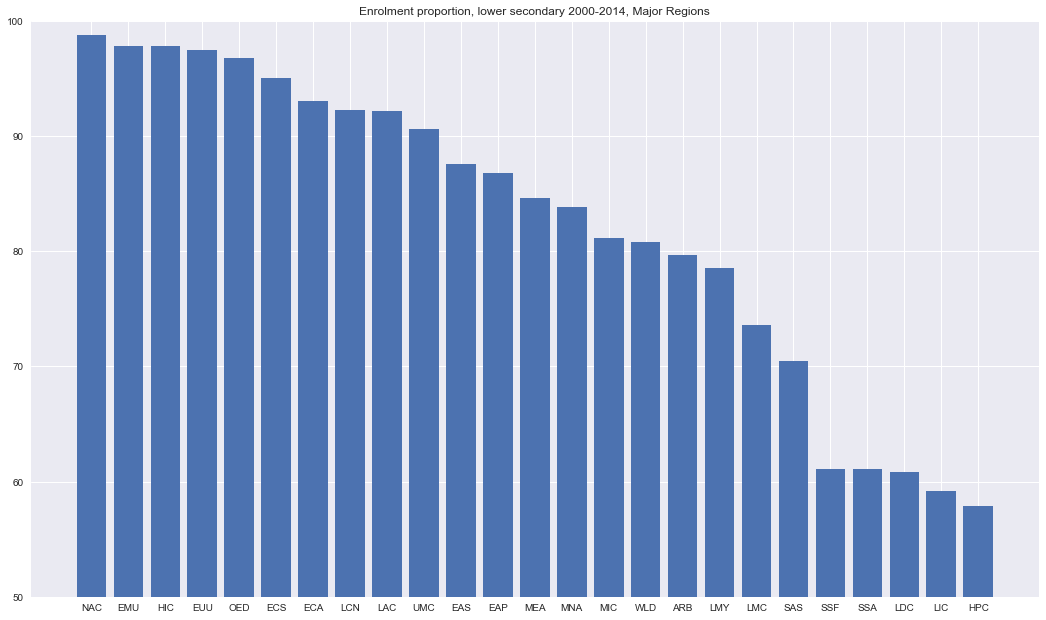

In [11]:

avg_x = list(df_enr_2_regions.sort_values(by='average', ascending=False)["Country Code"])
avg_y = list(df_enr_2_regions.sort_values(by='average', ascending=False)["average"])

figr1 = plt.figure(figsize=(14, 8))
axr1 = figr1.add_axes([0,0,1,1])
axr1.bar(avg_x, avg_y, width=0.8)
axr1.set_ylim(50, 100)
title_r1 = "Enrolment proportion, lower secondary 2000-2014, Major Regions"

axr1.set_title(title_r1)
plt.show()


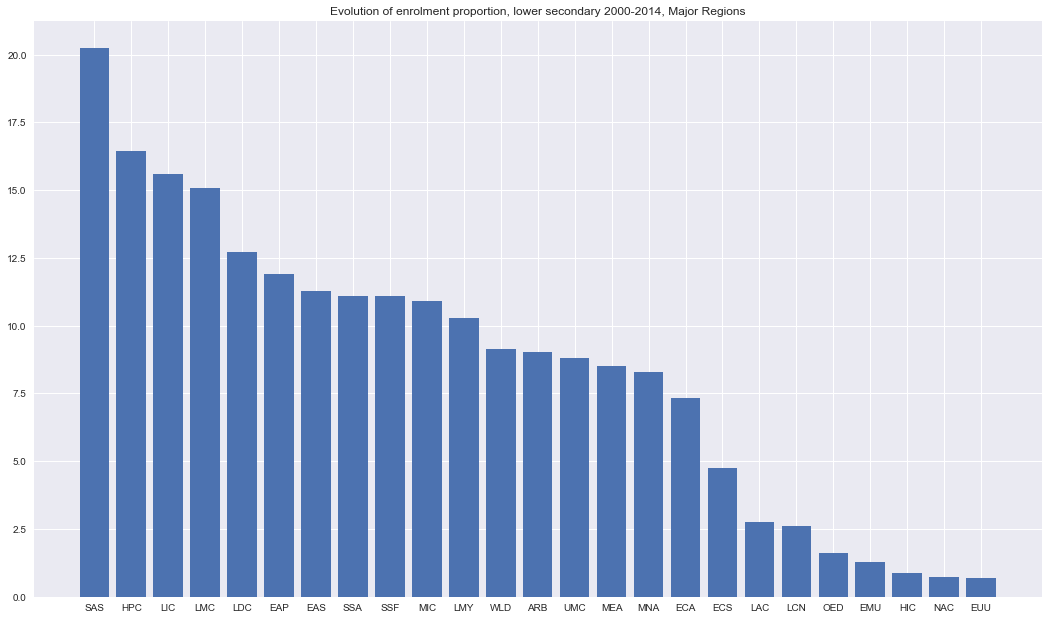

In [12]:

avg_x = list(df_enr_2_regions.sort_values(by='evolution', ascending=False)["Country Code"])
avg_y = list(df_enr_2_regions.sort_values(by='evolution', ascending=False)["evolution"])

figr2 = plt.figure(figsize=(14, 8))
axr2 = figr2.add_axes([0,0,1,1])
axr2.bar(avg_x, avg_y, width=0.8)
title_r2 = "Evolution of enrolment proportion, lower secondary 2000-2014, Major Regions"

axr2.set_title(title_r2)
plt.show()


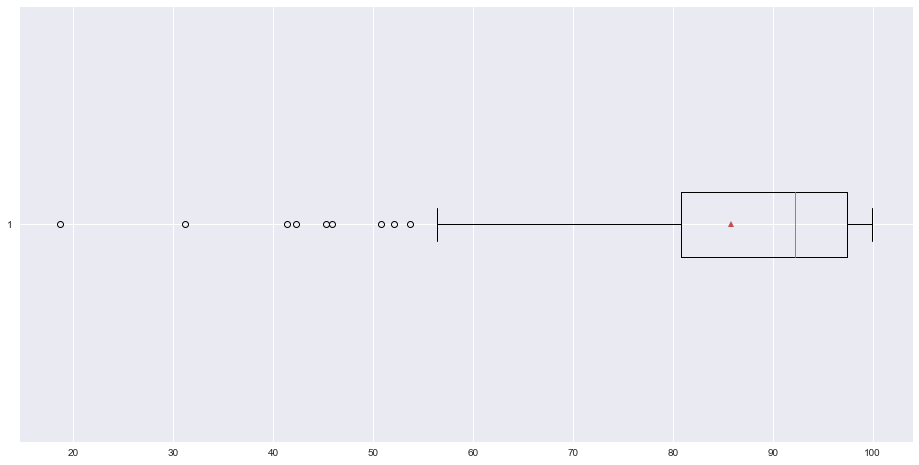

In [13]:

box_avg_x = df_enr_2["Country Code"]
box_avg_y = df_enr_2["average"]

box = plt.figure(figsize=(16, 8))
plt.boxplot(box_avg_y, vert=0, showmeans=True)
plt.show()


Le graphique ci dessus met en evidence l'innégalité moyenne du jeu de donnée total (115 pays ayant au maximum 10 donnees manquantes). -> "dropna(thresh=10)" permet de garder les entrées présentant moins de 10 données manquantes (thresh est ajustable pour modifier la sensibilité de la selection)

In [14]:

top_20_by_avg = df_enr_2.sort_values("average", ascending=False).head(n=20).reset_index(drop=True)
top_20_by_avg = top_20_by_avg[["Country Name", "Country Code", "average"]]
top_20_by_ev = df_enr_2.sort_values("evolution", ascending=False).head(n=20).reset_index(drop=True)
top_20_by_ev = top_20_by_ev[["Country Name", "Country Code", "evolution"]]


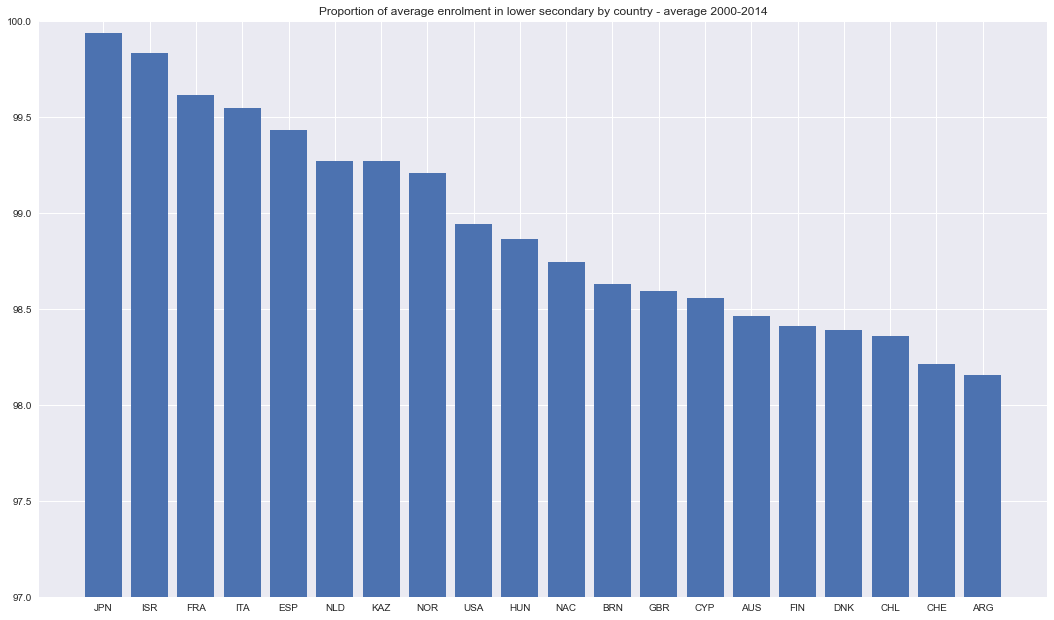

In [15]:

avg_x = list(top_20_by_avg["Country Code"])
avg_y = list(top_20_by_avg["average"])

fig = plt.figure(figsize=(14, 8))
ax = fig.add_axes([0,0,1,1])
ax.bar(avg_x, avg_y, width=0.8)
ax.set_ylim(97, 100)
title_1 = "Proportion of average enrolment in lower secondary by country - average 2000-2014"

ax.set_title(title_1)
plt.show()


In [16]:
top_20_by_avg

,Country Name,Country Code,average
0,Japan,JPN,99.937066
1,Israel,ISR,99.834848
2,France,FRA,99.611219
3,Italy,ITA,99.548240
4,Spain,ESP,99.430556
5,Netherlands,NLD,99.269449
6,Kazakhstan,KAZ,99.269364
7,Norway,NOR,99.209422
8,United States,USA,98.943837
9,Hungary,HUN,98.865791


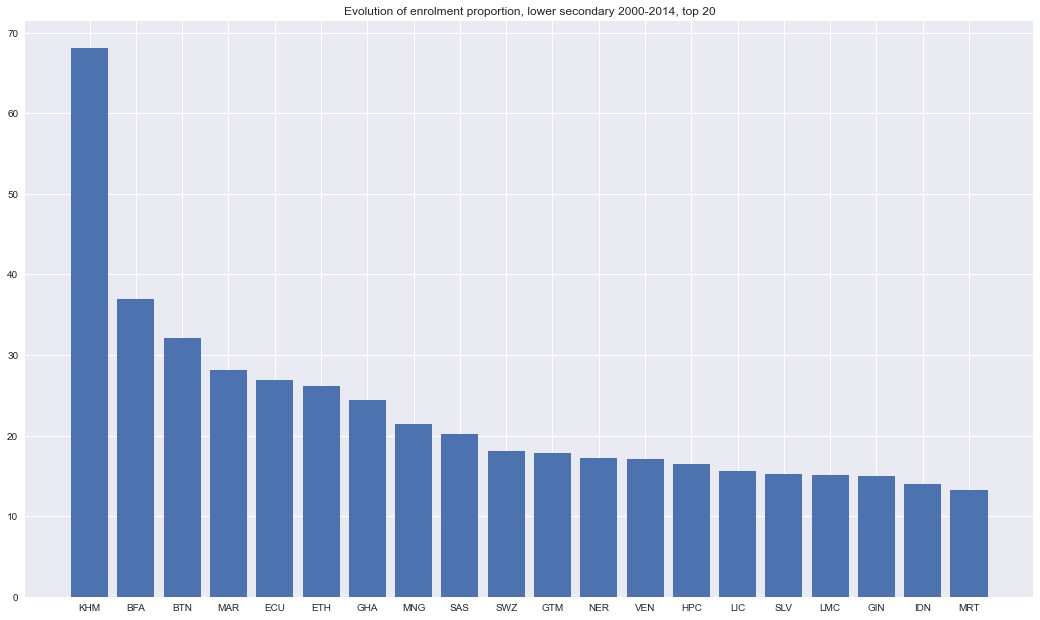

In [17]:

avg_x = list(top_20_by_ev["Country Code"])
avg_y = list(top_20_by_ev["evolution"])

fig2 = plt.figure(figsize=(14, 8))
ax2 = fig2.add_axes([0,0,1,1])
ax2.bar(avg_x, avg_y, width=0.8)
# ax2.set_ylim(95, 100)
title_2 = "Evolution of enrolment proportion, lower secondary 2000-2014, top 20"

ax2.set_title(title_2)
plt.show()


In [18]:
top_20_by_ev

,Country Name,Country Code,evolution
0,Cambodia,KHM,68.060578
1,Burkina Faso,BFA,36.930889
2,Bhutan,BTN,32.142059
3,Morocco,MAR,28.187332
4,Ecuador,ECU,26.840149
5,Ethiopia,ETH,26.136299
6,Ghana,GHA,24.430946
7,Mongolia,MNG,21.462700
8,South Asia,SAS,20.234951
9,Swaziland,SWZ,18.115067


<h2>Etude des indicateurs Baro Lee dans le secondaire et le secteur universitaire</h2>

Dans le dataset, seules les etudes portant sur les années 2000, 2005 et 2010 sont présentes sur ces indicateurs, ils sont donc sans doute obsolètes mais ils devraient nous permettre d'observer deux indications :
- La proportion des 14/19 ans dans le secondaire et de 15/25 ans dans le secteur universitaire
- La proportion de completion des études secondaires et universitaires pour ces deux tranches d'âges
- Seule l'année la plus récente sera utilisée (2010)
- L'indicateur montre déjà par le manque de regularité des études un taux de valeurs manquantes très élevé

In [19]:
baro_lee_indicators = [ind for ind in indicators_list if ind.startswith("BAR.")]

df_barolee = df_stats[df_stats['Indicator Code'].isin(baro_lee_indicators)].reset_index(drop=True)

country_b_list = []

Country_b = namedtuple(
    "Country_b",
    [
        "c_code",
        "c_name",
        "pop_15_19_nc",
        "pop_20_24_nc"
    ]
)

for country in unique_countries:

    temp_df = df_barolee[df_barolee["Country Code"].isin([country])]
    
    secondary_all = temp_df[temp_df["Indicator Code"].isin(["BAR.SEC.ICMP.1519.ZS"])]["2010"]
    secondary_comp = temp_df[temp_df["Indicator Code"].isin(["BAR.SEC.CMPT.1519.ZS"])]["2010"]
    secondary_inc = float(secondary_all) - float(secondary_comp)
    
    tertiary_all = temp_df[temp_df["Indicator Code"].isin(["BAR.TER.ICMP.2024.ZS"])]["2010"]
    tertiatry_conp = temp_df[temp_df["Indicator Code"].isin(["BAR.TER.CMPT.2024.ZS"])]["2010"]
    tertiary_inc = float(tertiary_all) - float(tertiatry_conp)

    
    if np.isnan(secondary_inc) or np.isnan(tertiary_inc):
        continue  # Skipping NANs

    else:
        entry = Country_b(
            c_code=country,
            c_name=str(df_country.loc[(df_country['Country Code'] == country)]["Short Name"].values[0]),
            pop_15_19_nc=secondary_inc,
            pop_20_24_nc=tertiary_inc
        )

        country_b_list.append(entry)


In [20]:

df_result_bl = pd.DataFrame(country_b_list, columns=["Country Code", "Country Name","incomplete_2", "incomplete_3"])


In [21]:
df_result_bl.sort_values(by=["incomplete_2"], ascending=False)

,Country Code,Country Name,incomplete_2,incomplete_3
34,DNK,Denmark,92.48,4.15
41,FIN,Finland,86.68,3.47
99,NOR,Norway,84.94,12.40
63,ITA,Italy,83.67,3.66
55,HUN,Hungary,81.86,3.82
...,...,...,...,...
54,HTI,Haiti,7.31,0.27
117,SGP,Singapore,6.58,17.45
37,ECU,Ecuador,1.40,3.50
71,KOR,Korea,0.65,71.18


<h4>Problème de l'indicateur :</h4>

En triant les valeurs par ordre decroissant, on voit apparaitre des pays qui ne correspondent pas à notre recherche : l'indicateur montre que, dans des pays tels que le Danmark ou la Findlande, le taux d'incompletion dans le secondaire est superieur à 85% - Cela à sans doute à voir avec le systeme éducatif propre à chaque pays et à la tranche d'âge restrictive de l'indicateur (15-19). <br>
Dans les cas des pays du Nord, l'éducation dans le secondaire (que l'on assimile au Lycée francais) varie en âge et un fort taux d'incompletion ne prend pas en compte le fait, par exemple, que dans l'éducation secondaire de certains pays, la fin du secondaire soit atteinte à un âge superieur à 19ans <a href="https://en.wikipedia.org/wiki/Education_in_Denmark#Secondary_education">(Page wikipedia traitant sur le secondaire au Danemark par exemple)</a>. Le classement selon cet indicateur peut dont être totalement invalidé par le système scolaire propre à certains pays. <br>
Nous pouvons voir s'il en va de même pour les études superieures :

In [22]:
df_result_bl.sort_values(by=["incomplete_3"], ascending=False)

,Country Code,Country Name,incomplete_2,incomplete_3
71,KOR,Korea,0.65,71.18
61,ISL,Iceland,60.21,53.11
137,USA,United States,41.64,43.14
135,UKR,Ukraine,41.08,37.02
112,RUS,Russia,39.32,35.28
...,...,...,...,...
142,ZMB,Zambia,66.34,0.20
93,MWI,Malawi,10.65,0.06
27,COG,Congo,56.64,0.02
49,GTM,Guatemala,22.53,0.00


<h5>Une fois encore : l'indicateur est fortement influencé par la restriction par tranche d'age</h5>
- Des pays comme la Coree et les Etats Unis privilegient des études superieures longues, il est donc logique de trouver un fort taux de non completion dans le supérieur pour ces pays où la separation par tranche d'âge (ici 20-24 ans) ne permet pas de dresser de conclusion globale, les indicateurs de Baro Lee ne seront donc pas pris en compte lors du scoring.
<hr><hr>

<h4><u>Démographie cible :</u></h4>
<h5>Personnes agées de 15 à 24 ans ayant un accés à internet</h5>
- Indicateurs : IT.NET.USER.P2 (utilisateurs d'internet/100 personnes) * SP.POP.1524.TO.UN (population agée de 15 à 24 ans) <br>
- On s'intéresse majoritairement aux valeurs les plus récentes

In [23]:
dem_ind = ["IT.NET.USER.P2", "SP.POP.1524.TO.UN"]

df_demography = df_stats.loc[df_stats['Indicator Code'].isin(dem_ind)].reset_index(drop=True)

dem_non_nan = df_enr_2.count().sum()
dem_nans = df_enr_2.isnull().sum().sum()

percentage_na_dem = (dem_nans / (dem_nans + dem_non_nan)) * 100

print("Missing values = ", dem_nans)
print("Values = ", dem_non_nan)
print("Percentage of missing values = [(missing values) / number of cells] * 100")
print("Percentage of missing values = ", percentage_na_dem, "%")


Missing values =  269
Values =  1916
Percentage of missing values = [(missing values) / number of cells] * 100
Percentage of missing values =  12.311212814645309 %


<h4>Pour cet indicateur, le taux de valeurs manquantes est d'environ 12.31%</h4>

In [24]:
# Finding the latest year available for each indicator :

latest_year_internet = 1900
latest_year_pop_survey = 1900

df_pop = df_demography[df_demography["Indicator Code"].isin(["SP.POP.1524.TO.UN"])]
df_internet = df_demography[df_demography["Indicator Code"].isin(["IT.NET.USER.P2"])]

for index, series in df_pop.iterrows():
    last_idx = series.last_valid_index()
    try:
        if int(last_idx) > latest_year_pop_survey:
            latest_year_pop_survey = int(last_idx)
    except ValueError:
        pass


for index, series in df_internet.iterrows():
    last_idx = series.last_valid_index()
    try:
        if int(last_idx) > latest_year_internet:
            latest_year_internet = int(last_idx)
    except ValueError:
        pass


print("Dernier sondage internet = ", latest_year_internet)
print("Dernier sondage demography = ", latest_year_pop_survey)

# Remove regions from df : 

df_demography = df_demography[~df_demography["Country Code"].isin(c_code_list)].reset_index(drop=True)


Dernier sondage internet =  2016
Dernier sondage demography =  2015


In [25]:

# Calculate target demography

last_study = 2015


Country = namedtuple("Country", ["code", "name", "dem_w_internet"])

country_list = []

for country in unique_countries:

    series_pop = df_pop.loc[df_pop["Country Code"] == country]
    series_int = df_pop.loc[df_pop["Country Code"] == country]

    if str(last_study) in series_pop and str(last_study) in series_int:
        country = Country(
            code=list(series_pop["Country Code"])[0],
            name=list(series_pop["Country Name"])[0],
            dem_w_internet=float(series_pop[str(last_study)]) * float(series_int[str(last_study)])
        )
        country_list.append(country)

    else:
        pass


df_result = pd.DataFrame(country_list, columns=["Country Code", "Country Name", "Target Demography"])

df_result = df_result.sort_values("Target Demography", ascending=False).dropna()


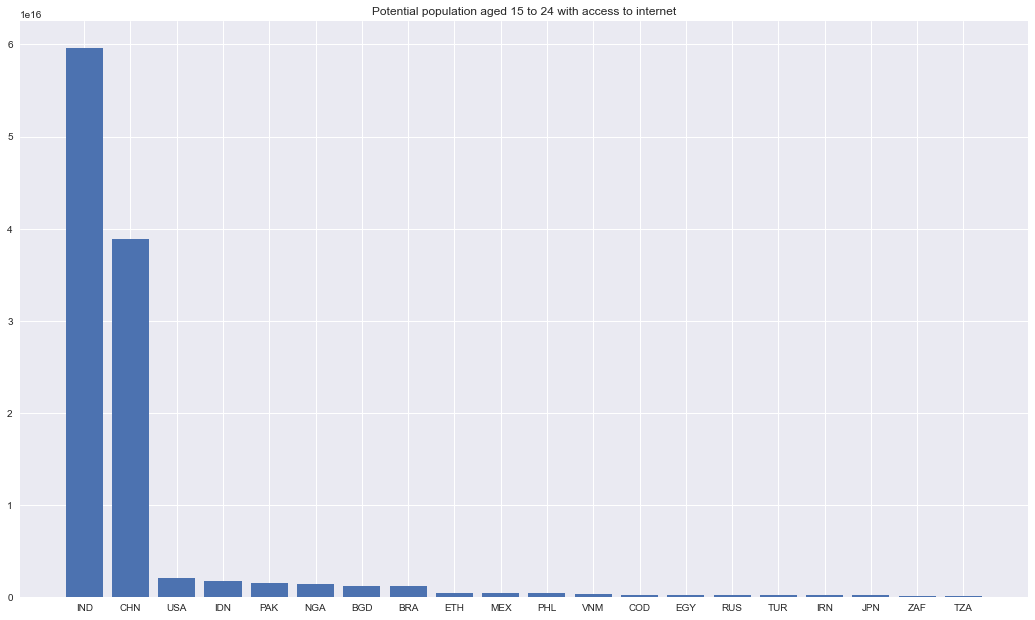

In [26]:

# Plotting target demography

plot_results = df_result.head(n=20)

avg_x = list(plot_results["Country Code"])
avg_y = list(plot_results["Target Demography"])

fig_d = plt.figure(figsize=(14, 8))
ax_d = fig_d.add_axes([0,0,1,1])
ax_d.bar(avg_x, avg_y, width=0.8)
title_d = "Potential population aged 15 to 24 with access to internet"

ax_d.set_title(title_d)
plt.show()


Le graphe ci dessus montre très clairement l'Inde et la Chine comme des pays potentiellements riches en étudiants potentiels pour <i>Academy</i>. Les autres pays figurant dans le top 20 ayant la demographie cible sont également des possibilités très intéréssantes. (Ci dessous)

In [27]:

chnind = ["CHN", "IND"]
plot_results = plot_results[plot_results["Country Code"].isin(chnind) == False]


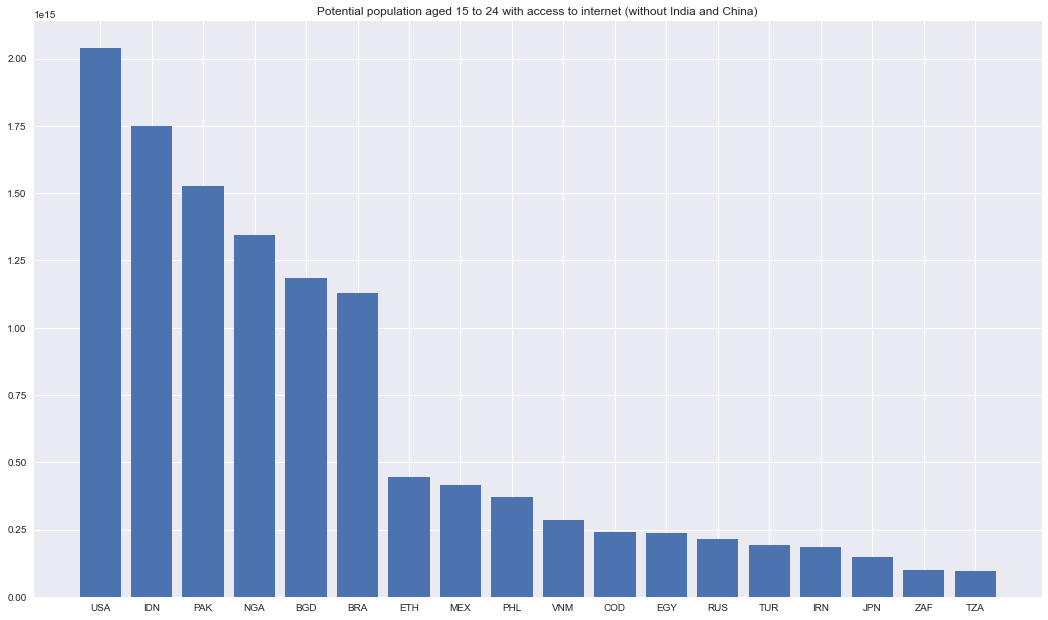

In [28]:
avg_x = list(plot_results["Country Code"])
avg_y = list(plot_results["Target Demography"])

fig_d = plt.figure(figsize=(14, 8))
ax_d = fig_d.add_axes([0,0,1,1])
ax_d.bar(avg_x, avg_y, width=0.8)
title_d = "Potential population aged 15 to 24 with access to internet (without India and China)"

ax_d.set_title(title_d)
plt.show()


<h3>Purchasing power per capita</h3>
- Le pouvoir d'achat par habitant peut également être un bon indicateur pour fournir à <i>Academy</i> les pays où les profits seraient susceptible d'être plus élevés.


In [29]:

df_ppp = df_stats.loc[df_stats['Indicator Code'] == "NY.GDP.PCAP.PP.KD"]

df_ppp = df_ppp[~df_ppp["Country Code"].isin(c_code_list)].reset_index(drop=True)

latest_year_ppp = 1900

for index, series in df_ppp.iterrows():
    last_idx = series.last_valid_index()
    try:
        if int(last_idx) > latest_year_ppp:
            latest_year_ppp = int(last_idx)
    except ValueError:
        pass

print("Latest reliable survey year = ", latest_year_ppp)


Latest reliable survey year =  2016


In [30]:

for year in range(2000, latest_year_ppp, 1):
    try:
        del df_ppp[str(year)]
    except (IndexError, KeyError):
        pass

# More data cleaning
try:
    del df_ppp["Indicator Name"]
    del df_ppp["Indicator Code"]
    del df_ppp["2017"]

except KeyError:
    pass

df_ppp = df_ppp.dropna()

df_ppp = df_ppp.sort_values(by="2016", ascending=False).reset_index(drop=True)

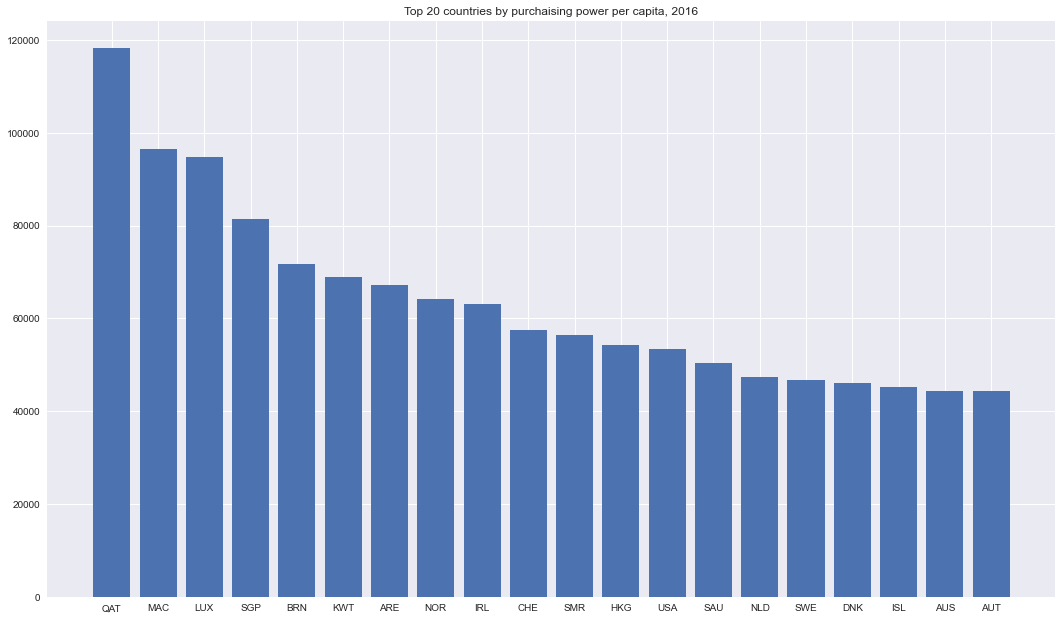

In [31]:

ppp_plot = df_ppp.head(n=20)

ax_x = list(ppp_plot["Country Code"])
ax_y = list(ppp_plot["2016"])

fig_p = plt.figure(figsize=(14, 8))
ax_p = fig_p.add_axes([0,0,1,1])
ax_p.bar(ax_x, ax_y, width=0.8)
title_p = "Top 20 countries by purchaising power per capita, 2016"

ax_p.set_title(title_p)
plt.show()


In [32]:
# Rating :

# unique_countries = Countries + Unions
# c_code_list = Unions
print("countries + regions len = ", len(unique_countries))
print("regions len = ", len(c_code_list))

countries_only = [country for country in unique_countries if country not in list(c_code_list)]

print("Sovereign countries only len = ", len(countries_only))


countries + regions len =  241
regions len =  25
Sovereign countries only len =  216


In [33]:

df_rating = pd.DataFrame(data=countries_only, columns=["country_code"])

# adding empty cols :

columns = [
    "country_name",
    "average_2",
    "evo_2",
    "target_dem",
    "ppp",
    "combined_rating",
]

# -1 Value means unrated

for column in columns:
    df_rating[column] = -1


# Removing regions from results dfs : 

df_enr_2 = df_enr_2[~df_enr_2["Country Code"].isin(c_code_list)].reset_index(drop=True)
df_target_dem = df_result  # Unions and Regions already filtered
df_ppp


,Country Name,Country Code,2016
0,Qatar,QAT,118207.134623
1,"Macao SAR, China",MAC,96565.889805
2,Luxembourg,LUX,94764.974767
3,Singapore,SGP,81443.356456
4,Brunei Darussalam,BRN,71788.783234
...,...,...,...
176,Niger,NER,914.467036
177,Liberia,LBR,753.557379
178,"Congo, Dem. Rep.",COD,743.894342
179,Burundi,BDI,721.176562


In [34]:
# Assigning ranks : 

df_enr_2_av = df_enr_2.sort_values(by="average", ascending=True).reset_index(drop=True)
df_enr_2_ev = df_enr_2.sort_values(by="evolution", ascending=True).reset_index(drop=True)
df_target_dem = df_target_dem.sort_values(by="Target Demography", ascending=True).reset_index(drop=True)
df_ppp = df_ppp.sort_values(by="2016", ascending=True).reset_index(drop=True)

ratings_cols = ["average_2", "evo_2", "target_dem", "ppp"]

for c_code in countries_only:

    rank_avg_2 = get_rank(country_code=c_code, df=df_enr_2_av)
    rank_ev_2 = get_rank(country_code=c_code, df=df_enr_2_ev)
    rank_target_dem = get_rank(country_code=c_code, df=df_target_dem)
    rank_ppp = get_rank(country_code=c_code, df=df_ppp)
    values_list = [rank_avg_2, rank_ev_2, rank_target_dem, rank_ppp]
    try:
        df_rating.loc[df_rating["country_code"] == c_code, ratings_cols] = values_list
    except KeyError:
        pass


In [35]:
df_rating

,country_code,country_name,average_2,evo_2,target_dem,ppp,combined_rating
0,ABW,-1,47,25,0,-1,-1
1,AFG,-1,-1,-1,150,17,-1
2,AGO,-1,-1,-1,127,60,-1
3,ALB,-1,-1,-1,53,89,-1
4,AND,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...
211,XKX,-1,-1,-1,-1,80,-1
212,YEM,-1,-1,-1,144,28,-1
213,ZAF,-1,-1,-1,162,94,-1
214,ZMB,-1,-1,-1,118,44,-1
